In [9]:
## Importing the necessary libraries.

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings  
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow import keras
from keras import optimizers, regularizers
from keras.layers import Flatten, Dense, BatchNormalization, Dropout  
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [10]:
import h5py
h5 = h5py.File('/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5','r')

h5.keys()


<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [11]:
X_train = h5['X_train']
y_train = h5['y_train']

X_test = h5['X_test']
y_test = h5['y_test']

X_val = h5['X_val']
y_val = h5['y_val']

In [13]:
# Checking the shape of the dataset
print('X_train:', X_train.shape,'\n',
      'y_train:', y_train.shape,'\n\n',
      
      'X_test:',  X_test.shape,'\n',
      'y_test:',  y_test.shape,'\n\n',
      
      'X_val:',   X_val.shape,'\n',
      'y_val:',   y_val.shape,sep='')

X_train:(42000, 32, 32)
y_train:(42000,)

X_test:(18000, 32, 32)
y_test:(18000,)

X_val:(60000, 32, 32)
y_val:(60000,)


### The dataset contains 42000 training images size of 32*32 with their corresponding labels and 18000 test data points to check the model performance using accuracy metric

Label:  7


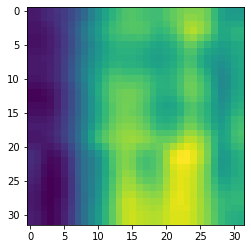

In [14]:
## Displaying a random image from each of training and test sets to confirm if data is fetched correctly.

plt.imshow(X_train[15050])    # seeing some random number in the dataset
print('Label: ', y_train[15050])


## ● Reshape and normalize the train and test features (10 points)

In [15]:
## Reshaping the data columns from 32×32 to 1024 features/columns in the dataset
## as a single array of data is to be set for the model training for each instance

X_train = X_train.value.reshape(42000, 1024) # 1024 which is of 32*32
print(X_train.shape)

X_test = X_test.value.reshape(18000, 1024)
print(X_test.shape)

X_val = X_val.value.reshape(60000, 1024)
print(X_val.shape)

(42000, 1024)
(18000, 1024)
(60000, 1024)


In [16]:
# Normalizing the data from 0-255 to 0-1 by dividing the inputs by 255.

# Before normalising
print(X_train.max())
print(X_train.min())

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# After normalising
print(X_train.max())
print(X_train.min())

254.9745
0.0
0.9999
0.0


#### After normalizing we can see that all the values lies between 0 and 1

In [17]:
# We should check the proportion of each class in the target variable 
# to ensure there is no imbalance in the ground truth values.

l = pd.DataFrame(y_train)
l[0].value_counts()

3    4281
5    4232
2    4197
9    4196
7    4192
8    4188
4    4188
0    4186
1    4172
6    4168
Name: 0, dtype: int64

### It looks fine, all the labels are more or less equally distributed.

## ● One hot encode the labels for train and test data (15 points)

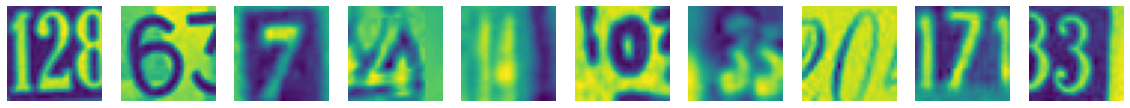

label for each of the above images: [2 6 7 4 4 0 3 0 7 3]


In [18]:
# visualizing the first 10 images in the dataset and their labels

plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32, 32))
    plt.axis('off')
plt.show()
print('label for each of the above images: {}'.format(y_train[0:10]))
    

Encoding the target variables. We need to one hot encode the labels for the model to understand the labels better. We will be using categorical cross entropy as our loss function and for this purpose we need our labels to be in one hot encoded format.

In [19]:
# Before converting the labels to one hot encoder
print(y_train[10])

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# After converting the labels to one hot encoder
print(y_train[10])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### One-hot encoding is essentially the representation of categorical variables as binary vectors. These categorical values are first mapped to integer values. Each integer value is then represented as a binary vector that is all 0s (except the index of the integer which is marked as 1).

## ● Define the model architecture using TensorFlow with a flatten layer followed by dense layers with activation as ReLu and softmax (15 points)

Linear layer, ReLU activation layer, Batch normalization layer classes are created along with cross entropy and softmax. Stochastic gradient descent function performs the back propagation with gradient flow through all the layers in reverse order. The original batch is divided into multiple mini batches with shuffled images and then each minibatch data is made to pass through layers in feedforward method and then back propagated after the loss is computed.



Sigmoid functions suffer from gradient vanishing problem, making training slower

ReLU (rectified linear unit) is one of the most popular ones, hence we will use ReLU

In [20]:
# Creating a vannila models with simple neural network with less number of hidden layers
# and no hyper parameters inside to check the model performance

# Initializing the constructor
model = Sequential()

# Defining the model architecture with 512 neurons in the first hidden layer
model.add(Dense(512, input_shape=(1024,), kernel_initializer='he_uniform', activation='relu'))

model.add(Dense(256,kernel_initializer='he_uniform', activation='relu'))

model.add(Dense(128,kernel_initializer='he_uniform', activation='relu'))

# Output layer with 10 neurons which is equal to 10 classes in the dataset
model.add(Dense(10, activation='softmax'))

In [21]:
# Checking the summary of the model which shows number of parameters to learn and number of layers in the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model with Categorical_crossentory as the loss function and using vanilla SGD as the optimizer technique
# and accuracy as the metric to check the model performance
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [23]:
# Running the model with 20 epochs and 200 as the batch size
history = model.fit(X_train, y_train, epochs=20, batch_size=200, validation_split=.2, verbose=1)

Epoch 1/20
168/168 [==============================] - 4s 23ms/step - loss: 2.3124 - accuracy: 0.1168 - val_loss: 2.2662 - val_accuracy: 0.1836
Epoch 2/20
168/168 [==============================] - 3s 20ms/step - loss: 2.2549 - accuracy: 0.1924 - val_loss: 2.2271 - val_accuracy: 0.2396
Epoch 3/20
168/168 [==============================] - 3s 19ms/step - loss: 2.2135 - accuracy: 0.2513 - val_loss: 2.1771 - val_accuracy: 0.2962
Epoch 4/20
168/168 [==============================] - 3s 20ms/step - loss: 2.1637 - accuracy: 0.2981 - val_loss: 2.1240 - val_accuracy: 0.3170
Epoch 5/20
168/168 [==============================] - 3s 20ms/step - loss: 2.0911 - accuracy: 0.3452 - val_loss: 2.0389 - val_accuracy: 0.3773
Epoch 6/20
168/168 [==============================] - 3s 20ms/step - loss: 2.0150 - accuracy: 0.3760 - val_loss: 1.9436 - val_accuracy: 0.4176
Epoch 7/20
168/168 [==============================] - 3s 20ms/step - loss: 1.9203 - accuracy: 0.4134 - val_loss: 1.8446 - val_accuracy: 0.4249

In [24]:
# Checking the accuracy on test data
loss, accuracy = model.evaluate(X_test,y_test)

563/563 [==============================] - 2s 3ms/step - loss: 1.1599 - accuracy: 0.6561


### The simple neural network we created shows around 66% accuracy on test data which is very low.
### SGD is known for slow convergence hence model is performing poorly.
### We will try to change the optimizer to 'adam' and check the accuracy.

### Here Model architecture remains same, so the summary also,  only changing optimizer

In [25]:
# Creating a vannila model with simple dense neural network with less number of hidden layers
# and with no hyper parameters inside to check the model performance

# Initializing the constructor
model1 = Sequential()

# Defining the model architecture with 512 neurons in the first hidden layer
model1.add(Dense(512, input_shape=(1024,), kernel_initializer='he_uniform', activation='relu'))

# Adding input layer with activation function as Relu
# Using he_uniform technique for initializing the weights as it works best with relu activation function
model1.add(Dense(256,kernel_initializer='he_uniform', activation='relu'))

model1.add(Dense(128,kernel_initializer='he_uniform', activation='relu'))

# Output layer with 10 neurons which is equal to 10 classes in the dataset
model1.add(Dense(10, activation='softmax'))

In [26]:
# Compiling the model with same parameters but with 'adam' optimizer
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# Running the model with 20 epochs and 200 as the batch size
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=200, validation_split=.2, verbose=1)

Epoch 1/20
168/168 [==============================] - 5s 25ms/step - loss: 2.3311 - accuracy: 0.1219 - val_loss: 2.0013 - val_accuracy: 0.2611
Epoch 2/20
168/168 [==============================] - 4s 22ms/step - loss: 1.7892 - accuracy: 0.3810 - val_loss: 1.3892 - val_accuracy: 0.5457
Epoch 3/20
168/168 [==============================] - 4s 22ms/step - loss: 1.3028 - accuracy: 0.5799 - val_loss: 1.2096 - val_accuracy: 0.6061
Epoch 4/20
168/168 [==============================] - 4s 23ms/step - loss: 1.1260 - accuracy: 0.6477 - val_loss: 1.0571 - val_accuracy: 0.6714
Epoch 5/20
168/168 [==============================] - 4s 23ms/step - loss: 1.0294 - accuracy: 0.6796 - val_loss: 1.0013 - val_accuracy: 0.6905
Epoch 6/20
168/168 [==============================] - 4s 23ms/step - loss: 0.9542 - accuracy: 0.7009 - val_loss: 0.9761 - val_accuracy: 0.6990
Epoch 7/20
168/168 [==============================] - 4s 22ms/step - loss: 0.9082 - accuracy: 0.7150 - val_loss: 0.9190 - val_accuracy: 0.7243

In [28]:
# Checking the accuracy on test data using adam optimizer
loss, accuracy = model1.evaluate(X_test,y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.7389 - accuracy: 0.7773


### The simple neural network we created shows around 64% accuracy on test data which is very low.
### SGD is known for slow convergence hence model is performing poorly.
### We will try to change the optimizer to 'adam' and check the accuracy.

### Here Model architecture remains same, so the summary also,  only changing optimizer

In [29]:
# Creating a vannila model with simple dense neural network with less number of hidden layers
# and with no hyper parameters inside to check the model performance

# Initializing the constructor
model1 = Sequential()

# Defining the model architecture with 512 neurons in the first hidden layer
model1.add(Dense(512, input_shape=(1024,), kernel_initializer='he_uniform', activation='relu'))

# Adding input layer with activation function as Relu
# Using he_uniform technique for initializing the weights as it works best with relu activation function
model1.add(Dense(256,kernel_initializer='he_uniform', activation='relu'))

model1.add(Dense(128,kernel_initializer='he_uniform', activation='relu'))

# Output layer with 10 neurons which is equal to 10 classes in the dataset
model1.add(Dense(10, activation='softmax'))

In [30]:
# Compiling the model with same parameters but with 'adam' optimizer
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# Running the model with 20 epochs and 200, as the batch size
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=200, validation_split=.2, verbose=1)

Epoch 1/20
168/168 [==============================] - 4s 23ms/step - loss: 2.3241 - accuracy: 0.1125 - val_loss: 2.0573 - val_accuracy: 0.2524
Epoch 2/20
168/168 [==============================] - 4s 22ms/step - loss: 1.8895 - accuracy: 0.3239 - val_loss: 1.4228 - val_accuracy: 0.5360
Epoch 3/20
168/168 [==============================] - 4s 22ms/step - loss: 1.3498 - accuracy: 0.5650 - val_loss: 1.2712 - val_accuracy: 0.5950
Epoch 4/20
168/168 [==============================] - 4s 22ms/step - loss: 1.1463 - accuracy: 0.6358 - val_loss: 1.1426 - val_accuracy: 0.6335
Epoch 5/20
168/168 [==============================] - 4s 22ms/step - loss: 1.0609 - accuracy: 0.6681 - val_loss: 1.0102 - val_accuracy: 0.6765
Epoch 6/20
168/168 [==============================] - 4s 22ms/step - loss: 0.9355 - accuracy: 0.7087 - val_loss: 0.9338 - val_accuracy: 0.7165
Epoch 7/20
168/168 [==============================] - 4s 22ms/step - loss: 0.8941 - accuracy: 0.7218 - val_loss: 0.9392 - val_accuracy: 0.7106

In [32]:
# Checking the accuracy on test data using adam optimizer
loss, accuracy = model1.evaluate(X_test,y_test)

563/563 [==============================] - 2s 4ms/step - loss: 0.6971 - accuracy: 0.7908


### Neural Network model with adam optimizer shows significant improvement in terms of accuracy in both training and test data
### Adam optimizer is the powerful optimisation technique, Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

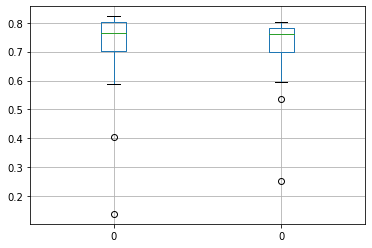

In [33]:
# Here we are checking the training and validation accuracies to measure the performance of the model

# Dataframe to store training accuracy
ta = pd.DataFrame(history1.history['accuracy'])

# Dataframe to store validation accuracy
va = pd.DataFrame(history1.history['val_accuracy'])

# Concatinating both the dataframes
tva = pd.concat([ta,va], axis=1)

# Creating the boxplot to see the difference between both the accuracies
tva.boxplot()

### By observing the training and test accuracies using above two boxplots we can say that both are looking same and overlapping each other, hence model can be generalizable, where highesh accuracy is somewhere around 82%(training) and 79%(validation) and ~75% is the median score for both training and validation.
### We will try to improve the accuracy by adding more hidden layers and also by doing the hyper parameter tuning using grid search technique.

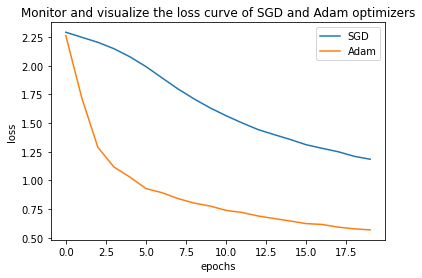

In [34]:
plt.title('Monitor and visualize the loss curve of SGD and Adam optimizers')
plt.plot(history.history['loss'],label='SGD');
plt.plot(history1.history['loss'],label='Adam');
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right');

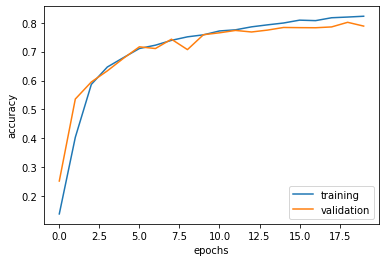

In [35]:
# Training and validation accuracies across the epochs
plt.plot(ta,label='training');
plt.plot(va,label='validation');
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right');

#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Here we will write a small class with one function to change the parameters and calling this function with different parameters to check the performance of the neural network model

In [36]:
class NeuralNetwork():
    def __init__(self):
        self.m=[]
        self.n=[]

    def train_and_test_loop(self,iterations,Lambda,optimizers,verb=True):
        
        # Initializing the Artificial Neural Network Classifier (Sequential)
        model = Sequential()

        # Adding input layer with activation function Relu
        model.add(Dense(512, input_shape = (1024,), kernel_initializer='he_uniform', activation ='relu'))

        # Second hidden layer
        model.add(Dense(256, kernel_initializer='he_uniform', activation='relu')) 
 
        # Third hidden layer   
        model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))

        # Fourth hidden layer
        model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))

        # Output layer with softmax activation function
        model.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(Lambda)))
    
        # Compile model
        model.compile(optimizer = optimizers, loss='categorical_crossentropy', metrics=['accuracy'],)
    
        # Fit the model
        history = model.fit(X_train, y_train, epochs=iterations, validation_split=.2, batch_size=200, verbose= 1)
    
        # Storing all the accuracy across epochs
        self.m.append(history.history['accuracy'])
        self.n.append(history.history['val_accuracy'])
    
        # Checking accuracy on test set and corresponding loss
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print('Test Accuracy: {:.2f}%'.format(accuracy*100))
        print('Test Loss: {:.3f}'.format(loss))

### Using 'SGD' optimizer to update the weights in each epoch and 'categorical_crossentropy' as loss function and 'accuracy' as the metric to monitor

In [37]:
# creating an object for class to invoke the function inside it
sgd_model = NeuralNetwork()
Lambda = 1e-4
sgd = optimizers.SGD(lr=0.01)
sgd_model.train_and_test_loop(20, Lambda, sgd)

Epoch 1/20
168/168 [==============================] - 4s 23ms/step - loss: 2.3139 - accuracy: 0.1231 - val_loss: 2.2601 - val_accuracy: 0.1774
Epoch 2/20
168/168 [==============================] - 4s 21ms/step - loss: 2.2433 - accuracy: 0.2067 - val_loss: 2.2034 - val_accuracy: 0.2305
Epoch 3/20
168/168 [==============================] - 3s 21ms/step - loss: 2.1833 - accuracy: 0.2699 - val_loss: 2.1292 - val_accuracy: 0.2970
Epoch 4/20
168/168 [==============================] - 4s 21ms/step - loss: 2.0895 - accuracy: 0.3445 - val_loss: 2.0039 - val_accuracy: 0.3592
Epoch 5/20
168/168 [==============================] - 4s 21ms/step - loss: 1.9600 - accuracy: 0.3851 - val_loss: 1.8544 - val_accuracy: 0.4251
Epoch 6/20
168/168 [==============================] - 3s 21ms/step - loss: 1.8373 - accuracy: 0.4106 - val_loss: 1.7194 - val_accuracy: 0.4552
Epoch 7/20
168/168 [==============================] - 3s 21ms/step - loss: 1.7199 - accuracy: 0.4510 - val_loss: 1.6306 - val_accuracy: 0.4664

### Loss is not decreasing and accuracy is slowly increasing as SGD is know to slow convergence even after using learning rate and optimization technques
### Even if we increase the number of epochs, accuracy would barely goes up (slowly)

##### --------------------------------------------------------------------------------------------------------------------------------------------------------------------

## ● Compile the model with loss as categorical cross-entropy and adam optimizers. Use accuracy as the metric for evaluation (10 points)

In [39]:
# creating another object for class to invoke the function inside it
adam_model = NeuralNetwork()
Lamda = 1e-4
adam = optimizers.Adam(lr=0.001)
adam_model.train_and_test_loop(20, Lamda, adam)

Epoch 1/20
168/168 [==============================] - 5s 26ms/step - loss: 2.3297 - accuracy: 0.1058 - val_loss: 2.2276 - val_accuracy: 0.1606
Epoch 2/20
168/168 [==============================] - 4s 24ms/step - loss: 2.1310 - accuracy: 0.1875 - val_loss: 1.7780 - val_accuracy: 0.3725
Epoch 3/20
168/168 [==============================] - 4s 24ms/step - loss: 1.6492 - accuracy: 0.4271 - val_loss: 1.3609 - val_accuracy: 0.5512
Epoch 4/20
168/168 [==============================] - 4s 23ms/step - loss: 1.3469 - accuracy: 0.5579 - val_loss: 1.2039 - val_accuracy: 0.6095
Epoch 5/20
168/168 [==============================] - 4s 23ms/step - loss: 1.1740 - accuracy: 0.6224 - val_loss: 1.0623 - val_accuracy: 0.6706
Epoch 6/20
168/168 [==============================] - 4s 23ms/step - loss: 1.0742 - accuracy: 0.6587 - val_loss: 1.0264 - val_accuracy: 0.6829
Epoch 7/20
168/168 [==============================] - 4s 23ms/step - loss: 0.9945 - accuracy: 0.6870 - val_loss: 0.9867 - val_accuracy: 0.6868

## ● Fit and evaluate the model. Print the loss and accuracy for the test 

1.   List item
2.   List item

data (5 points)

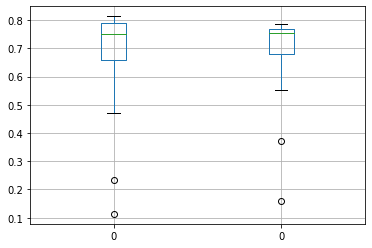

In [40]:
# Here we are checking the training and validation accuracies to measure the performance of the model

# Dataframe to store training accuracy
ts = pd.DataFrame(list(np.array(adam_model.m).flatten()))

# Dataframe to store validation accuracy
vs = pd.DataFrame(list(np.array(adam_model.n).flatten()))

# Concatinating both the dataframes
tvs = pd.concat([ts,vs], axis=1)

# Creating the boxplot to see the difference between both the accuracies
tvs.boxplot()

### The accuracy of the model on training and test set using ADAM with learning rate=0.001 has shown significant improvement.
### We can observe that from the Third epoch the accuracy is increasing significantly, that's the beauty of adam optimizer
### The last line of the log file shows the test loss and test accuracy which is 78.33%, we can say it is performing better.
### Will try to increase the number of epoch and see whether it performs even better or overfits?

In [41]:
# creating another object for class to invoke the function inside it
adam_model2 = NeuralNetwork()
Lamda = 1e-4
adam2 = optimizers.Adam(lr=0.001)

# ObjectName.FunctionName to invoke the function inside the class
adam_model2.train_and_test_loop(50, Lamda, adam2)

Epoch 1/50
168/168 [==============================] - 4s 23ms/step - loss: 2.3307 - accuracy: 0.1105 - val_loss: 2.1669 - val_accuracy: 0.2274
Epoch 2/50
168/168 [==============================] - 4s 21ms/step - loss: 2.0193 - accuracy: 0.2768 - val_loss: 1.6389 - val_accuracy: 0.4236
Epoch 3/50
168/168 [==============================] - 4s 21ms/step - loss: 1.4401 - accuracy: 0.5236 - val_loss: 1.2331 - val_accuracy: 0.6062
Epoch 4/50
168/168 [==============================] - 4s 22ms/step - loss: 1.2186 - accuracy: 0.6087 - val_loss: 1.2429 - val_accuracy: 0.5942
Epoch 5/50
168/168 [==============================] - 4s 21ms/step - loss: 1.1134 - accuracy: 0.6505 - val_loss: 1.0693 - val_accuracy: 0.6635
Epoch 6/50
168/168 [==============================] - 4s 21ms/step - loss: 1.0092 - accuracy: 0.6838 - val_loss: 0.9820 - val_accuracy: 0.6980
Epoch 7/50
168/168 [==============================] - 4s 21ms/step - loss: 0.9581 - accuracy: 0.6976 - val_loss: 0.9137 - val_accuracy: 0.7190

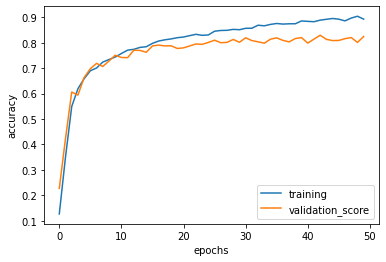

In [42]:
plt.plot(list(np.array(adam_model2.m).flatten()),label='training');
plt.plot(list(np.array(adam_model2.n).flatten()),label='validation_score');
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right');

### By looking at the accuracy curves of both training and testing, we could say that it is leading to overfit. As the number of epochs increases the model tries to fit the data so well that it tends to become overfit thus validation accuracy comes down as you can see in the above plot.

### By running the model only on 20 epochs we are getting better accuracy and it can be generalizable

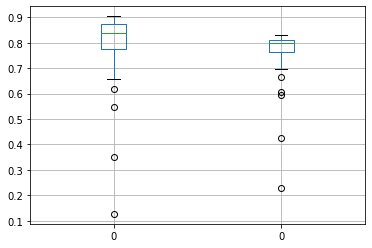

In [43]:
# Here we are checking the training and validation accuracies to measure the performance of the model

# Dataframe to store training accuracy
ts = pd.DataFrame(list(np.array(adam_model2.m).flatten()))

# Dataframe to store validation accuracy
vs = pd.DataFrame(list(np.array(adam_model2.n).flatten()))

# Concatinating both the dataframes
tvs = pd.concat([ts,vs], axis=1)

# Creating the boxplot to see the difference between both the accuracies
tvs.boxplot()

### Above boxplot also tells the same, two boxplots are not much identical, hence we reduce the number of epochs or we can also use gridsearch to find out the optimal no. of epochs

### Using GridSearchCV from the sklearn package we try to fit the models with all the combinations specified as a parameter grid to find out best parameters which gives better accuracy.
### The Keras library provides wrapper classes to allow us to use neural network models developed with Keras in scikit-learn.
###  KerasClassifier class in Keras can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

In [44]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        
        # in the first iteration we will add the input layers with one hidden layer
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1], activation=activation))
        
        # then from the next iterations we will be adding the number of hidden layers specified in the list
        else:
            
            model.add(Dense(nodes,activation=activation))
    # at last output layer       
    model.add(Dense(10, activation='softmax')) # no activation beyond this point
    
    # compiling the model with the same parameters
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=1)

In [45]:
# here minimum will be one hidden layer and max going to be 3 hidden layers 
# and also the number of nodes in each hidden layers are the values in the list of tuples
layers = [(256,), (256, 128), (512, 256, 128)]

# checking with two activation functions 
activations = ['relu', 'sigmoid']

# comibining both hyperparameters into one dictionary
param_grid = dict(layers=layers, activation=activations, batch_size = [256, 128], epochs=[20])

# instantiating the object for GridSearchCV method
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [47]:
# Fitting the model with training data
grid_result = grid.fit(X_train, y_train)

Epoch 1/20
132/132 [==============================] - 2s 10ms/step - loss: 2.3360 - accuracy: 0.1155
Epoch 2/20
132/132 [==============================] - 1s 10ms/step - loss: 2.2048 - accuracy: 0.2090
Epoch 3/20
132/132 [==============================] - 1s 10ms/step - loss: 2.0125 - accuracy: 0.3199
Epoch 4/20
132/132 [==============================] - 1s 10ms/step - loss: 1.7862 - accuracy: 0.4273
Epoch 5/20
132/132 [==============================] - 1s 10ms/step - loss: 1.6031 - accuracy: 0.5077
Epoch 6/20
132/132 [==============================] - 1s 10ms/step - loss: 1.4655 - accuracy: 0.5582
Epoch 7/20
132/132 [==============================] - 1s 10ms/step - loss: 1.3447 - accuracy: 0.6087
Epoch 8/20
132/132 [==============================] - 1s 9ms/step - loss: 1.2728 - accuracy: 0.6205
Epoch 9/20
132/132 [==============================] - 1s 10ms/step - loss: 1.2182 - accuracy: 0.6449
Epoch 10/20
132/132 [==============================] - 1s 10ms/step - loss: 1.1603 - accurac

In [48]:
# Checking the best score and associated parameters
[grid_result.best_score_,grid_result.best_params_]

[0.7797380924224854,
 {'activation': 'relu',
  'batch_size': 128,
  'epochs': 20,
  'layers': (512, 256, 128)}]

In [49]:
# Checking the score of the test data
grid_result.score(X_test,y_test)

141/141 [==============================] - 1s 7ms/step - loss: 0.6797 - accuracy: 0.7986


0.7985555529594421

141/141 [==============================] - 1s 7ms/step

prediction: 8
actual 8


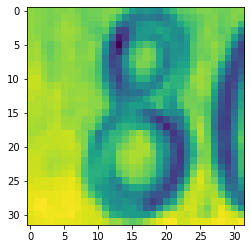

In [52]:
# Predicting random test data point with the actual value in the test set
print('\nprediction:',grid_result.predict(X_test)[4340])

# Seeing the actual image and label
print('actual',np.argmax(y_test[4340]))
plt.imshow(X_test[4340].reshape(32,32));

In [53]:
# Creating a model with the parameters obtained from gridsearch to see the performance

# Initializing the constructor
model = Sequential()

# Defining the model architecture with 512 neurons in the first hidden layer
model.add(Dense(512, input_shape=(1024,), kernel_initializer='he_uniform',activation='relu'))

model.add(Dense(256, kernel_initializer='he_uniform', activation='relu'))

model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))

# Output layer with 10 neurons which is equal to 10 classes in the dataset
model.add(Dense(10, kernel_initializer='he_uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

history = model.fit(X_train, y_train, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

Epoch 1/20
168/168 [==============================] - 5s 25ms/step - loss: 2.3495 - accuracy: 0.1114 - val_loss: 2.0971 - val_accuracy: 0.2676
Epoch 2/20
168/168 [==============================] - 4s 23ms/step - loss: 1.9224 - accuracy: 0.3187 - val_loss: 1.4453 - val_accuracy: 0.5212
Epoch 3/20
168/168 [==============================] - 4s 23ms/step - loss: 1.3577 - accuracy: 0.5560 - val_loss: 1.2112 - val_accuracy: 0.6237
Epoch 4/20
168/168 [==============================] - 4s 23ms/step - loss: 1.1397 - accuracy: 0.6390 - val_loss: 1.2334 - val_accuracy: 0.6077
Epoch 5/20
168/168 [==============================] - 4s 23ms/step - loss: 1.0484 - accuracy: 0.6689 - val_loss: 0.9823 - val_accuracy: 0.7019
Epoch 6/20
168/168 [==============================] - 4s 23ms/step - loss: 0.9576 - accuracy: 0.7046 - val_loss: 0.9882 - val_accuracy: 0.6912
Epoch 7/20
168/168 [==============================] - 4s 23ms/step - loss: 0.9063 - accuracy: 0.7182 - val_loss: 0.9519 - val_accuracy: 0.7020

In [54]:
# Checking accuracy on test set and corresponding loss
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Loss: {:.3f}'.format(loss))

Accuracy: 78.02%
Loss: 0.735


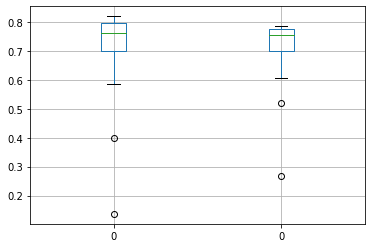

In [55]:
# Here we are checking the training and validation accuracies to measure the performance of the model

# Dataframe to store training accuracy
ts = pd.DataFrame(history.history['accuracy'])

# Dataframe to store validation accuracy
vs = pd.DataFrame(history.history['val_accuracy'])

# Concatinating both the dataframes
tvs = pd.concat([ts,vs], axis=1)

# Creating the boxplot to see the difference between both the accuracies
tvs.boxplot()

### Using Hyperparameters tuning technique though we are not getting high accuracy but the model is not overfitting

In [56]:
# Prediction
y_predict = model.predict(X_test)

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [58]:
# Taking max of individual prediction scores and storing it
y_pred = []
for i in y_predict:
    y_pred.append(np.argmax(i))

In [59]:
# Converting back from one hot to single values i.e 0-9
y_test1 =[]
for j in y_test:
    y_test1.append(np.argmax(j))

In [60]:
# Creating confusion matrix to compare between actuals and predictions
cm = confusion_matrix(y_test1,y_pred)
print(cm)

[[1423   64   36   27   34   21   77   49   38   45]
 [  20 1554   27   40   41   11   27   86   14    8]
 [  11   41 1420   49   19   24   16  173   21   29]
 [  10   79   58 1244   20  144   21  103   25   15]
 [  35   83   40   32 1448   34   64   17   21   38]
 [  22   50   24  117   10 1393   51   31   36   34]
 [  70   36   24   24   54   75 1432   26   79   12]
 [  15   72   49   17    5   19   17 1590    8   16]
 [  36   85   58   62   27   82  103   28 1283   48]
 [  56   63   55   53   28   91   20  120   62 1256]]


## Batch Normalization:
### Here we are introducing the regularization techniques called Batchnormalization and Dropout
### Batch normalization is applied to the layers that we choose to apply it within our network. It normalises the outputs of the previous layer i.e o/p's of the activation function
### This process makes that the weights within the netowrk dont become imbalance with extremely high or low values since the normalisation is included in the gradient process

## Dropout:
### It is a also a regularizatin technique. All that it does is dropping a percentage(user_defined) of neurons from every layer.
### These techniques reduces overfitting problem 

In [61]:
keras_model = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model.add(Dense(512, kernel_initializer='he_normal',input_shape = (1024,), activation ='relu'))
#Adding BatchNormalization Layer
keras_model.add(BatchNormalization())
#Adding dropout of 20%
keras_model.add(Dropout(0.2))

#Hidden Layer 1
#Adding first Hidden layer
keras_model.add(Dense(256, activation ='relu', kernel_initializer='he_normal'))
#Adding BatchNormalization Layer
keras_model.add(BatchNormalization())
#Adding dropout of 20%
keras_model.add(Dropout(0.2))

#Hidden Layer 2
#Adding second Hidden layer
keras_model.add(Dense(128, activation ='relu', kernel_initializer='he_normal'))
#Adding BatchNormalization Layer
keras_model.add(BatchNormalization())
#Adding dropout of 20%
keras_model.add(Dropout(0.2))

#Hidden Layer 3
#Adding third Hidden layer
keras_model.add(Dense(64, activation ='relu', kernel_initializer='he_normal'))
#Adding BatchNormalization Layer
keras_model.add(BatchNormalization())
keras_model.add(Dropout(0.2))

# #Hidden Layer 4
# #Adding fourth Hidden layer
# keras_model.add(Dense(32, activation ='relu', kernel_initializer='he_normal'))
# #Adding BatchNormalization Layer
# keras_model.add(BatchNormalization())
# #Adding dropout of 20%
# keras_model.add(Dropout(0.2))

# Output Layer
#Adding output layer which is of 10 nodes (digidts)
keras_model.add(Dense(10, activation='softmax'))


In [62]:
#Setting the learning rate in sgd
adam = optimizers.Adam(lr = 0.0001)
# compiling the ANN classifier
keras_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [63]:
# Fitting the ANN to the Training data
history_2 = keras_model.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 50, verbose = 1)

Epoch 1/50
210/210 [==============================] - 9s 36ms/step - loss: 2.8875 - accuracy: 0.1248 - val_loss: 2.1449 - val_accuracy: 0.2350
Epoch 2/50
210/210 [==============================] - 7s 32ms/step - loss: 2.2638 - accuracy: 0.2440 - val_loss: 1.7308 - val_accuracy: 0.4259
Epoch 3/50
210/210 [==============================] - 7s 33ms/step - loss: 1.9063 - accuracy: 0.3548 - val_loss: 1.4824 - val_accuracy: 0.5235
Epoch 4/50
210/210 [==============================] - 7s 33ms/step - loss: 1.6647 - accuracy: 0.4400 - val_loss: 1.2888 - val_accuracy: 0.5949
Epoch 5/50
210/210 [==============================] - 7s 33ms/step - loss: 1.5005 - accuracy: 0.5024 - val_loss: 1.1900 - val_accuracy: 0.6408
Epoch 6/50
210/210 [==============================] - 7s 33ms/step - loss: 1.3724 - accuracy: 0.5543 - val_loss: 1.1442 - val_accuracy: 0.6447
Epoch 7/50
210/210 [==============================] - 7s 33ms/step - loss: 1.2950 - accuracy: 0.5825 - val_loss: 1.0284 - val_accuracy: 0.6891

In [64]:
   # Checking accuracy on test set and corresponding loss
loss, accuracy = keras_model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}%'.format(accuracy))
print('Loss: {:.3f}'.format(loss))

Accuracy: 0.82%
Loss: 0.585


In [65]:
# Prediction
y_predict1 = keras_model.predict(X_test)
# Taking max of individual prediction scores and storing it
y_pred1 = []
for i in y_predict1:
    y_pred1.append(np.argmax(i))

In [66]:
# Creating confusion matrix to compare between actuals and predictions
cm = confusion_matrix(y_test1,y_pred1)
print(cm)

[[1563   59    9   30   26    3   23   33   14   54]
 [  34 1612   16   29   36   13   10   48   11   19]
 [  25   49 1436   52   35   16    3  120   15   52]
 [  18   62   35 1377   24   81   12   50   23   37]
 [  30   86   41   20 1545   12   17   12    6   43]
 [  18   26   13  148   17 1412   36   17   27   54]
 [  72   35   14   38   65   89 1386   17   85   31]
 [  18   92   27   24   14    7    4 1594    6   22]
 [  37   65   24   93   33   49   63   22 1320  106]
 [  54   54   18   54   28   31    5   34   23 1503]]


### So far we have built many neural network model which tries to classify the datapoints into 10 classes/labels
### Firstly implemented a vanilla neural network model without hyper parameters, checked the accuracy.
### Built models using two well know optimizers namely 'Stochastic Gradient Descent' and 'Adam' optimizers. Then we could conclude that Adam performs much better than SGD with 82 percent accuracy.
### Implemented a small function to try different learning rates and lambda values and built a neural network.
### Then we used GridSearchCV to find out the optimal parameters called how many hidden layes?, how many neurons in each hidden layers? with the help of KerasClassifier.
### Further we make use of different regularization techniques called BatchNormalization and Dropout and it was giving better accuracy than any other Neural Networks.
### Future implementations to get more accuracy:
*  We could try with range of learning rate values and weight decay using gridsearch technique. ( requires more training time ) 
* Try other optimizers like RMSPROP, ADADELTA..etc
* We can use 'momentum' parameter which reduces the training time..
* Here because of the dataset is contained with distractors we could not able to get the high accuracy as with MNIST Dataset
